# Phase Evolution Data Generation

Generate phase evolution data for 10 seeds of both isotropic (Cartesian) and circular bias (Polar) models.

**Parameters:**
- K = 1.0
- noise_scale = 0.0
- Save 100 evenly spaced frames from 5000 time steps
- Interpolate to 256x256 grid with circular phase interpolation
- Pad outside circle with zeros

In [1]:
import numpy as np
from scipy.interpolate import griddata
import time
import os
import matplotlib.pyplot as plt

from kuramoto_models import (
    setup_euclidean_grid,
    compute_coupling_cartesian,
    compute_coupling_polar,
    run_kuramoto_simulation
)

%matplotlib inline

## 1. Define Parameters

In [2]:
# Fixed parameters
N_euclidean = 50      # Grid resolution for oscillator positions
r_max = 1.0           # Spatial domain radius
K = 3.0               # Coupling strength
p_coupling = 0.25     # Connection probability
r_coupling = 0.4      # Coupling radius
omega_mean = 5.0      # Mean natural frequency
omega_std = 0.5       # Std dev of natural frequencies
noise_scale = 0.0     # No noise

# Polar coupling parameters
theta_scale = 1.0     # Angular distance scaling
r_scale = 1.0         # Radial distance scaling
Lx = 2 * np.pi        # Period for angular coordinate

# Time parameters
dt = 0.01             # Time step
T_total = 50.0        # Total simulation time
save_interval = 1     # Save every step (we'll downsample later)

# Output parameters
n_seeds = 7          # Number of random seeds
# seeds = np.arange(0, 10)  # Seeds 10-19
seeds = [4, 5, 6, 9, 12, 22, 26]
n_frames_to_save = 200     # Number of frames to save
output_resolution = 512    # Interpolate to 256x256 grid

# Output directory
output_dir = 'phase_data'
os.makedirs(output_dir, exist_ok=True)

print("=" * 80)
print("PHASE EVOLUTION DATA GENERATION")
print("=" * 80)
print(f"Parameters:")
print(f"  Coupling strength K: {K}")
print(f"  Noise scale: {noise_scale}")
print(f"  Number of seeds: {n_seeds}")
print(f"  Output resolution: {output_resolution}x{output_resolution}")
print(f"  Frames to save: {n_frames_to_save}")
print(f"  Output directory: {output_dir}")
print("=" * 80)

PHASE EVOLUTION DATA GENERATION
Parameters:
  Coupling strength K: 3.0
  Noise scale: 0.0
  Number of seeds: 7
  Output resolution: 512x512
  Frames to save: 200
  Output directory: phase_data


## 2. Setup Grid (Shared by All Seeds)

In [3]:
print("Setting up oscillator grid...")
x_points, y_points, theta_points, r_points, mask, X_grid, Y_grid = \
    setup_euclidean_grid(N_euclidean, r_max)

n_points = len(x_points)
print(f"Grid created: {n_points} oscillators")

Setting up oscillator grid...
Grid created: 1876 points within radius 1.0
Grid created: 1876 oscillators


## 3. Create Interpolation Grid

In [4]:
print(f"Creating {output_resolution}x{output_resolution} interpolation grid...")
x_interp = np.linspace(-r_max, r_max, output_resolution)
y_interp = np.linspace(-r_max, r_max, output_resolution)
X_interp, Y_interp = np.meshgrid(x_interp, y_interp)

# Create mask for circular domain (for padding with zeros)
R_interp = np.sqrt(X_interp**2 + Y_interp**2)
circle_mask = R_interp <= r_max

print(f"Interpolation grid created: {output_resolution}x{output_resolution}")
print(f"Points within circle: {circle_mask.sum()} / {output_resolution**2}")

Creating 512x512 interpolation grid...
Interpolation grid created: 512x512
Points within circle: 205012 / 262144


## 4. Define Circular Phase Interpolation Function

Since phases are angular values (periodic in [0, 2π]), we need special interpolation that respects the circular topology. We convert phases to complex numbers on the unit circle, interpolate the real and imaginary parts separately, then convert back to angles.

In [5]:
def interpolate_circular_phase(x_points, y_points, phase_values, X_interp, Y_interp, circle_mask):
    """
    Interpolate angular phase values using circular statistics.
    
    Phases are converted to unit complex numbers, interpolated separately
    for real and imaginary parts, then converted back to angles.
    
    Parameters:
    -----------
    x_points, y_points : ndarray
        Original oscillator coordinates
    phase_values : ndarray
        Phase values at original points (in radians)
    X_interp, Y_interp : ndarray
        Target interpolation grid
    circle_mask : ndarray
        Boolean mask for circular domain
        
    Returns:
    --------
    phase_interp : ndarray
        Interpolated phase values, with 0 outside circle
    """
    # Convert phases to complex numbers on unit circle
    z = np.exp(1j * phase_values)
    
    # Interpolate real and imaginary parts separately
    real_interp = griddata(
        points=(x_points, y_points),
        values=z.real,
        xi=(X_interp, Y_interp),
        method='linear',
        fill_value=0.0
    )
    
    imag_interp = griddata(
        points=(x_points, y_points),
        values=z.imag,
        xi=(X_interp, Y_interp),
        method='linear',
        fill_value=0.0
    )
    
    # Reconstruct complex numbers and convert back to angles
    z_interp = real_interp + 1j * imag_interp
    phase_interp = np.angle(z_interp)
    
    # Convert from [-π, π] to [0, 2π]
    phase_interp = np.mod(phase_interp, 2*np.pi)
    
    # Apply circular mask (set outside circle to 0)
    phase_interp[~circle_mask] = 0.0
    
    return phase_interp

print("Circular phase interpolation function defined.")

Circular phase interpolation function defined.


## 5. Main Loop: Generate Data for All Seeds

In [6]:
# Storage for results
phase_data_cartesian = []  # List of arrays (n_frames, 256, 256)
phase_data_polar = []      # List of arrays (n_frames, 256, 256)

for seed_idx, seed in enumerate(seeds):
    print(f"\n{'=' * 80}")
    print(f"PROCESSING SEED {seed} ({seed_idx + 1}/{n_seeds})")
    print(f"{'=' * 80}")
    
    np.random.seed(seed)
    
    # ========================================================================
    # GENERATE NATURAL FREQUENCIES (same for both models)
    # ========================================================================
    omega = omega_mean + omega_std * np.random.randn(n_points)
    print(f"Natural frequencies: mean={omega.mean():.3f}, std={omega.std():.3f}")
    
    # ========================================================================
    # CARTESIAN (ISOTROPIC) MODEL
    # ========================================================================
    print(f"\nRunning Cartesian (Isotropic) Model...")
    
    # Compute coupling
    np.random.seed(seed)  # Reset seed for connectivity
    coupling_cartesian = compute_coupling_cartesian(
        x_points, y_points, r_coupling, p_coupling
    )
    
    # Run simulation
    phase_history_cart, time_points = run_kuramoto_simulation(
        coupling_cartesian, omega, dt, T_total, save_interval,
        K=K, noise_scale=noise_scale, seed=seed, verbose=True
    )
    
    print(f"Cartesian simulation complete. Phase history shape: {phase_history_cart.shape}")
    
    # ========================================================================
    # POLAR (CIRCULAR BIAS) MODEL
    # ========================================================================
    print(f"\nRunning Polar (Circular Bias) Model...")
    
    # Compute coupling
    np.random.seed(seed)  # Reset seed for connectivity
    coupling_polar = compute_coupling_polar(
        theta_points, r_points, r_coupling, p_coupling,
        theta_scale=theta_scale, r_scale=r_scale, Lx=Lx
    )
    
    # Run simulation
    phase_history_polar, _ = run_kuramoto_simulation(
        coupling_polar, omega, dt, T_total, save_interval,
        K=K, noise_scale=noise_scale, seed=seed, verbose=True
    )
    
    print(f"Polar simulation complete. Phase history shape: {phase_history_polar.shape}")
    
    # ========================================================================
    # DOWNSAMPLE TO 100 FRAMES
    # ========================================================================
    print(f"\nDownsampling to {n_frames_to_save} frames...")
    
    n_total_frames = phase_history_cart.shape[1]
    frame_indices = np.linspace(0, n_total_frames - 1, n_frames_to_save, dtype=int)
    
    phase_history_cart_downsampled = phase_history_cart[:, frame_indices]
    phase_history_polar_downsampled = phase_history_polar[:, frame_indices]
    
    print(f"Downsampled shape: {phase_history_cart_downsampled.shape}")
    print(f"Time points saved: t = {time_points[frame_indices][0]:.2f} to {time_points[frame_indices][-1]:.2f}")
    
    # ========================================================================
    # INTERPOLATE TO 256x256 GRID WITH CIRCULAR PHASE INTERPOLATION
    # ========================================================================
    print(f"\nInterpolating to {output_resolution}x{output_resolution} grid (circular phase interpolation)...")
    
    # Storage for interpolated frames
    phase_grid_cart = np.zeros((n_frames_to_save, output_resolution, output_resolution))
    phase_grid_polar = np.zeros((n_frames_to_save, output_resolution, output_resolution))
    
    for frame_idx in range(n_frames_to_save):
        # Cartesian model
        phase_values_cart = phase_history_cart_downsampled[:, frame_idx]
        phase_grid_cart[frame_idx] = interpolate_circular_phase(
            x_points, y_points, phase_values_cart, X_interp, Y_interp, circle_mask
        )
        
        # Polar model
        phase_values_polar = phase_history_polar_downsampled[:, frame_idx]
        phase_grid_polar[frame_idx] = interpolate_circular_phase(
            x_points, y_points, phase_values_polar, X_interp, Y_interp, circle_mask
        )
        
        if (frame_idx + 1) % 20 == 0:
            print(f"  Interpolated {frame_idx + 1}/{n_frames_to_save} frames")
    
    print(f"Interpolation complete!")
    print(f"  Cartesian grid shape: {phase_grid_cart.shape}")
    print(f"  Polar grid shape: {phase_grid_polar.shape}")
    
    # Store results
    phase_data_cartesian.append(phase_grid_cart)
    phase_data_polar.append(phase_grid_polar)
    
    print(f"\nSeed {seed} processing complete!")

print(f"\n{'=' * 80}")
print("ALL SEEDS PROCESSED!")
print(f"{'=' * 80}")


PROCESSING SEED 4 (1/7)
Natural frequencies: mean=5.015, std=0.482

Running Cartesian (Isotropic) Model...
Computing coupling matrix (Cartesian distances)...
  Processed 500/1876 points
  Processed 1000/1876 points
  Processed 1500/1876 points
Coupling computed: 114114 total connections
Average connections per oscillator: 60.8
Converting to sparse matrix format...
Sparse matrix created: 114114 connections
Average connections: 60.8
Starting simulation...
Step 1000/5000 (t=10.0), elapsed: 0.3s
Step 2000/5000 (t=20.0), elapsed: 0.6s
Step 3000/5000 (t=30.0), elapsed: 0.9s
Step 4000/5000 (t=40.0), elapsed: 1.2s
Step 5000/5000 (t=50.0), elapsed: 1.5s
Simulation complete!
Cartesian simulation complete. Phase history shape: (1876, 5000)

Running Polar (Circular Bias) Model...
Computing coupling matrix (Polar distances)...
  Processed 500/1876 points
  Processed 1000/1876 points
  Processed 1500/1876 points
Coupling computed: 70209 total connections
Average connections per oscillator: 37.4
Con

## 6. Convert to Arrays and Save

In [7]:
print("Converting to arrays...")

# Convert lists to arrays: shape (n_seeds, n_frames, height, width)
phase_data_cartesian = np.array(phase_data_cartesian)
phase_data_polar = np.array(phase_data_polar)

print(f"Final data shapes:")
print(f"  Cartesian: {phase_data_cartesian.shape}")
print(f"  Polar: {phase_data_polar.shape}")

# Save as numpy arrays
cartesian_file = os.path.join(output_dir, 'phase_evolution_cartesian.npy')
polar_file = os.path.join(output_dir, 'phase_evolution_polar.npy')
metadata_file = os.path.join(output_dir, 'metadata.npz')

print(f"\nSaving arrays...")
np.save(cartesian_file, phase_data_cartesian)
print(f"  Saved: {cartesian_file}")

np.save(polar_file, phase_data_polar)
print(f"  Saved: {polar_file}")

# Save metadata
np.savez(
    metadata_file,
    seeds=seeds,
    time_points=time_points[frame_indices],
    K=K,
    noise_scale=noise_scale,
    r_max=r_max,
    output_resolution=output_resolution,
    n_frames=n_frames_to_save,
    x_interp=x_interp,
    y_interp=y_interp,
    circle_mask=circle_mask,
    omega_mean=omega_mean,
    omega_std=omega_std,
    r_coupling=r_coupling,
    p_coupling=p_coupling,
    N_euclidean=N_euclidean
)
print(f"  Saved: {metadata_file}")

print(f"\n{'=' * 80}")
print("SAVING COMPLETE!")
print(f"{'=' * 80}")
print(f"\nData structure:")
print(f"  - axis 0: seed index (0-9)")
print(f"  - axis 1: frame index (0-99)")
print(f"  - axis 2: y coordinate (0-255)")
print(f"  - axis 3: x coordinate (0-255)")
print(f"  - Values: phase in [0, 2π], with 0 padding outside circle")
print(f"\nFile sizes:")
print(f"  Cartesian: {phase_data_cartesian.nbytes / 1e6:.1f} MB")
print(f"  Polar: {phase_data_polar.nbytes / 1e6:.1f} MB")

Converting to arrays...
Final data shapes:
  Cartesian: (7, 200, 512, 512)
  Polar: (7, 200, 512, 512)

Saving arrays...
  Saved: phase_data\phase_evolution_cartesian.npy
  Saved: phase_data\phase_evolution_polar.npy
  Saved: phase_data\metadata.npz

SAVING COMPLETE!

Data structure:
  - axis 0: seed index (0-9)
  - axis 1: frame index (0-99)
  - axis 2: y coordinate (0-255)
  - axis 3: x coordinate (0-255)
  - Values: phase in [0, 2π], with 0 padding outside circle

File sizes:
  Cartesian: 2936.0 MB
  Polar: 2936.0 MB


## 7. Visualization: Example Frames

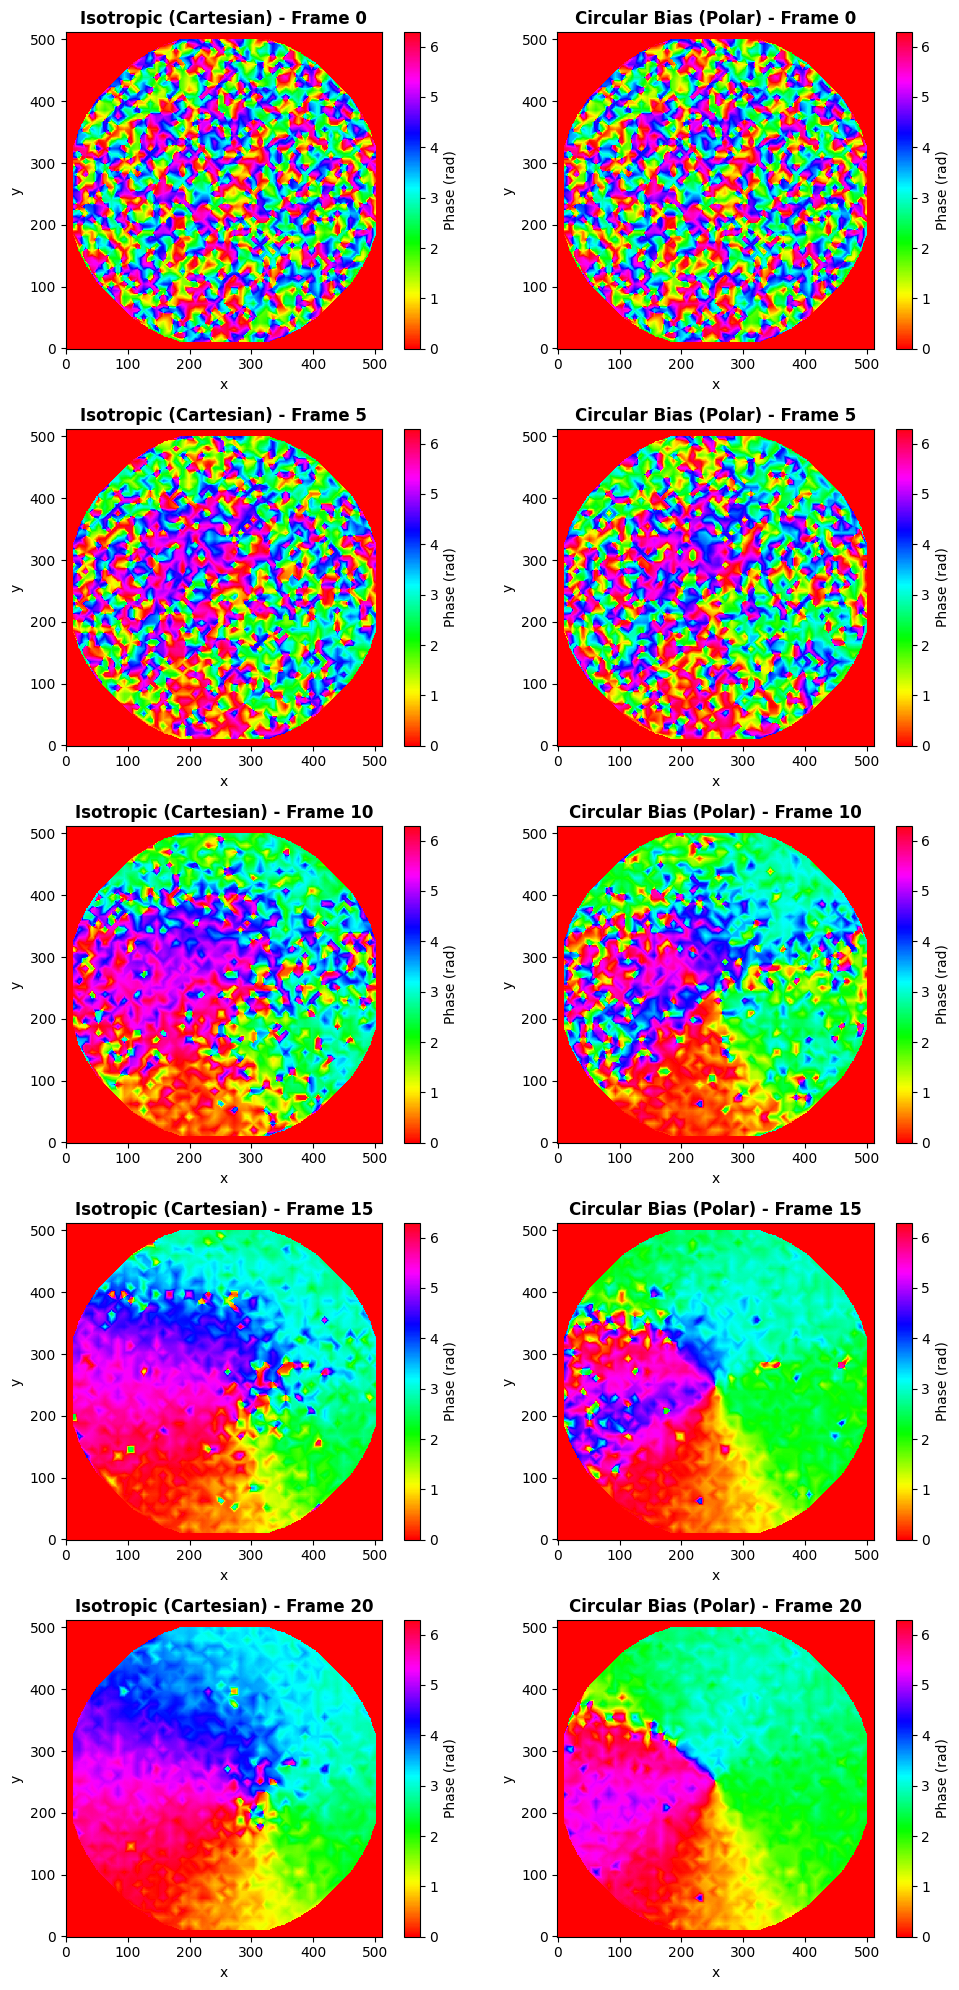

Example visualization saved to phase_data\example_frames.png


In [8]:
# Visualize example frames from first seed
# seed_all = [4, 5, 6, 9,12, 22, 26]
seed_idx = 6
frame_indices_to_plot = [0, 5, 10, 15, 20]  # Start, 1/3, 2/3, End

fig, axes = plt.subplots(len(frame_indices_to_plot), 2, figsize=(10, 4*len(frame_indices_to_plot)))

for i, frame_idx in enumerate(frame_indices_to_plot):
    # Cartesian
    im1 = axes[i, 0].imshow(phase_data_cartesian[seed_idx, frame_idx], interpolation='none',
                            cmap='hsv', vmin=0, vmax=2*np.pi, origin='lower')
    axes[i, 0].set_title(f'Isotropic (Cartesian) - Frame {frame_idx}', fontweight='bold')
    axes[i, 0].set_xlabel('x')
    axes[i, 0].set_ylabel('y')
    plt.colorbar(im1, ax=axes[i, 0], label='Phase (rad)')
    
    # Polar
    im2 = axes[i, 1].imshow(phase_data_polar[seed_idx, frame_idx], interpolation='none',
                            cmap='hsv', vmin=0, vmax=2*np.pi, origin='lower')
    axes[i, 1].set_title(f'Circular Bias (Polar) - Frame {frame_idx}', fontweight='bold')
    axes[i, 1].set_xlabel('x')
    axes[i, 1].set_ylabel('y')
    plt.colorbar(im2, ax=axes[i, 1], label='Phase (rad)')

plt.tight_layout()
# plt.savefig(os.path.join(output_dir, 'example_frames.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"Example visualization saved to {os.path.join(output_dir, 'example_frames.png')}")

## 8. Data Loading Example

For future use, here's how to load the saved data:

In [9]:
# Example: Load data
cartesian_loaded = np.load(cartesian_file)
polar_loaded = np.load(polar_file)
metadata_loaded = np.load(metadata_file)

print("Loaded data shapes:")
print(f"  Cartesian: {cartesian_loaded.shape}")
print(f"  Polar: {polar_loaded.shape}")
print(f"\nMetadata keys: {list(metadata_loaded.keys())}")
print(f"\nTime points: {metadata_loaded['time_points'][[0, -1]]}")
print(f"Seeds: {metadata_loaded['seeds']}")

Loaded data shapes:
  Cartesian: (7, 200, 512, 512)
  Polar: (7, 200, 512, 512)

Metadata keys: ['seeds', 'time_points', 'K', 'noise_scale', 'r_max', 'output_resolution', 'n_frames', 'x_interp', 'y_interp', 'circle_mask', 'omega_mean', 'omega_std', 'r_coupling', 'p_coupling', 'N_euclidean']

Time points: [ 0.   49.99]
Seeds: [ 4  5  6  9 12 22 26]
